# Dependencies

Using the following packages:
- [PyTorch](https://pytorch.org/): Deep Learning Library
- [Matplotlib](https://matplotlib.org/): For plotting the results
- [NumPy](https://numpy.org/): Basic Linear Algebra support (if needed)

In [1]:
import torch 
import numpy as np
import matplotlib.pyplot as plt

# For MNIST dataset
from torchvision import datasets

# MNIST Dataset

Using `torchvision` to import the MNIST dataset.

In [2]:
train_data = datasets.MNIST('./assets/data', train=True, download=True)
test_data = datasets.MNIST('./assets/data', train=False, download=True)

In [3]:
# Train and Test Arrays
X_train = []
y_train = []

X_test = []
y_test = []

for i in range(len(train_data)):
    img, label = train_data[i]
    # Saving the image data
    X_train.append(np.array(img))
    # Saving the label as onehot encoded vector
    onehot_label = np.zeros(10)
    onehot_label[label] = 1
    y_train.append(onehot_label)

for i in range(len(test_data)):
    img, label = test_data[i]
    # Saving the image data
    X_test.append(np.array(img))
    # Saving the label as onehot encoded vector
    onehot_label = np.zeros(10)
    onehot_label[label] = 1
    y_test.append(onehot_label)
    
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000, 10), (10000, 28, 28), (10000, 10))

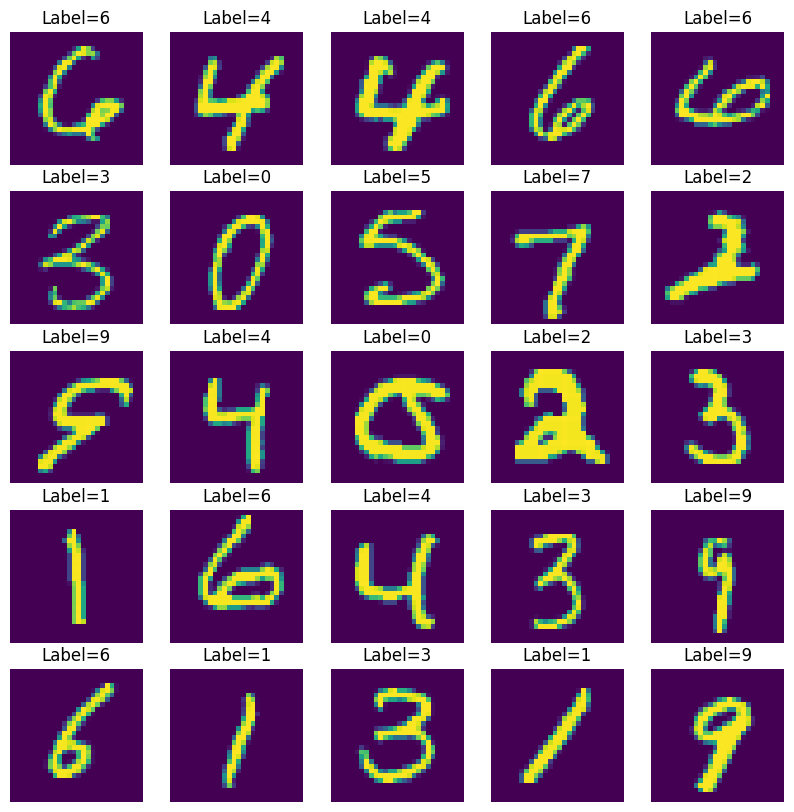

In [4]:
# Training Dataset
plt.figure(figsize=(10,10))

for i in range(1, 26):
    idx = np.random.randint(len(train_data))
    plt.subplot(5,5,i)
    plt.imshow(X_train[idx])
    plt.title("Label={}".format(np.where(y_train[idx] == 1)[0][0]))
    plt.axis("off")
plt.show()

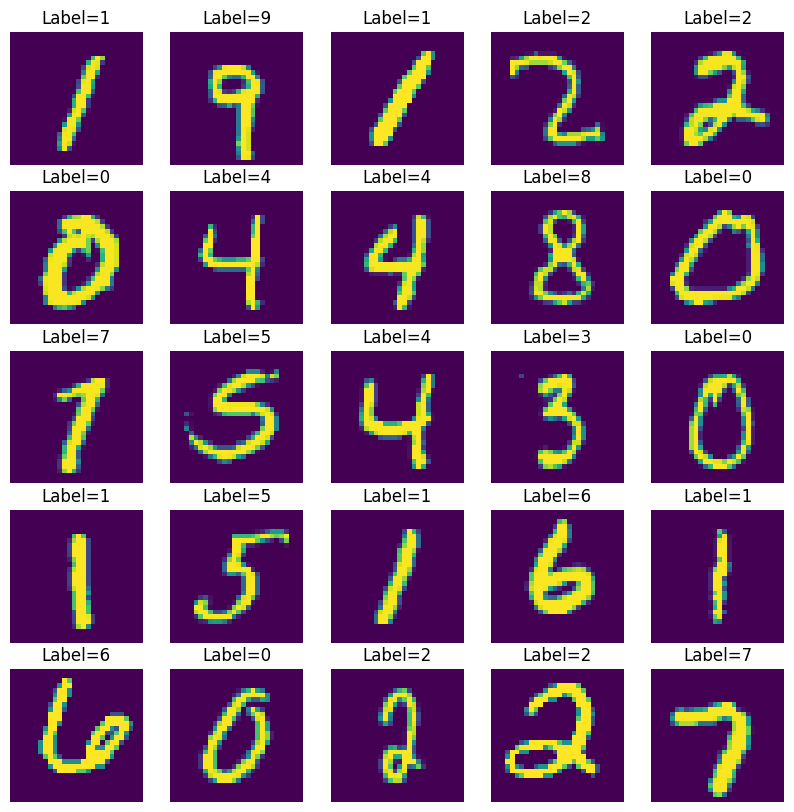

In [5]:
# Testing Dataset
plt.figure(figsize=(10,10))

for i in range(1, 26):
    idx = np.random.randint(len(test_data))
    plt.subplot(5,5,i)
    plt.imshow(X_test[idx])
    plt.title("Label={}".format(np.where(y_test[idx] == 1)[0][0]))
    plt.axis("off")
plt.show()

In [6]:
# Preprocessing Data
max_val = np.max(X_train)
X_train = torch.Tensor(X_train/max_val)
X_train = torch.reshape(X_train, (len(X_train), -1))
y_train = torch.Tensor(y_train)

X_test = torch.Tensor(X_test/max_val)
X_test = torch.reshape(X_test, (len(X_test), -1))
y_test = torch.Tensor(y_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([60000, 784]),
 torch.Size([60000, 10]),
 torch.Size([10000, 784]),
 torch.Size([10000, 10]))

# Neural Network

In [7]:
class Net(torch.nn.Module):
    def __init__(self, layers, activations):
        super().__init__()
        self.fc = torch.nn.ModuleList()
        self.act = torch.nn.ModuleList()
        for i in range(len(layers)-1):
            self.fc.append(torch.nn.Linear(layers[i], layers[i+1]))
            self.act.append(activations[i])
            
    def forward(self, x):
        for (activation, layer) in zip(self.fc, self.act):
            x = layer(x)
            x = activation(x)
        return x

# Loss Functions

So far I've defined:
- Mean Squared Error

In [8]:
def mean_squared_error(y_pred, y_test):
    return torch.mean((y_pred - y_test)**2)

# Training

In [9]:
# Hyper Parameters
EPOCHS = 10000
lr = 2e-3

In [13]:
# Initialising Network
nn = Net([X_train.shape[1], 16, 16, 8, 8, 10], 
         [torch.nn.Sigmoid(), torch.nn.Sigmoid(), torch.nn.Sigmoid(), torch.nn.Sigmoid(), torch.nn.Sigmoid()])

# Moving data and model to desired device
device = "mps"

nn.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Gradient Descent
optimizer = torch.optim.SGD(nn.parameters(), lr=lr)

train_acc = []
test_acc = []
for ep in range(EPOCHS):
    # Forward Pass
    y_pred = nn(X_train)
    
    # Loss
    l = mean_squared_error(y_pred, y_train)
    
    # Backward Pass to collect gradients
    l.backward()
    
    # Gradient Descent Update
    optimizer.step()
    optimizer.zero_grad()
    
    # Benchmarking
    with torch.no_grad():
        # Train Accuracy
        y_pred = torch.argmax(nn(X_train), dim=1)
        y_label = torch.argmax(y_train, dim=1)
        acc = torch.sum(y_pred == y_label)/len(y_label)
        train_acc.append(acc)
        
        y_pred = torch.argmax(nn(X_test), dim=1)
        y_label = torch.argmax(y_test, dim=1)
        acc = torch.sum(y_pred == y_label)/len(y_label)
        test_acc.append(acc)
    
    if ep%500 == 0:
        print("EPOCH: {}, TRAIN MSE: {}; TRAIN ACCURACY: {}, TEST ACCURACY: {}".format(ep, l.item(), train_acc[-1], test_acc[-1]))

EPOCH: 0, TRAIN MSE: 0.16456298530101776; TRAIN ACCURACY: 0.09871666878461838, TEST ACCURACY: 0.09799999743700027
EPOCH: 500, TRAIN MSE: 0.0899711325764656; TRAIN ACCURACY: 0.11236666887998581, TEST ACCURACY: 0.11349999904632568
EPOCH: 1000, TRAIN MSE: 0.0817919671535492; TRAIN ACCURACY: 0.21240000426769257, TEST ACCURACY: 0.21539999544620514
EPOCH: 1500, TRAIN MSE: 0.07826537638902664; TRAIN ACCURACY: 0.2904999852180481, TEST ACCURACY: 0.2822999954223633
EPOCH: 2000, TRAIN MSE: 0.06307436525821686; TRAIN ACCURACY: 0.4690333306789398, TEST ACCURACY: 0.46230000257492065
EPOCH: 2500, TRAIN MSE: 0.05325865373015404; TRAIN ACCURACY: 0.5897166728973389, TEST ACCURACY: 0.5888000130653381
EPOCH: 3000, TRAIN MSE: 0.04030875489115715; TRAIN ACCURACY: 0.6921333074569702, TEST ACCURACY: 0.6901999711990356
EPOCH: 3500, TRAIN MSE: 0.03615529462695122; TRAIN ACCURACY: 0.7195333242416382, TEST ACCURACY: 0.7181000113487244
EPOCH: 4000, TRAIN MSE: 0.02935311198234558; TRAIN ACCURACY: 0.7633333206176758